In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import scipy.io as sio

In [6]:
"""
data = sio.loadmat('mnist.mat')


Xtrain = data['trainX'][:10000,:].astype(int)
Xtest = data['testX'].astype(int)
ytrain =data['trainY'][0,:10000].astype(int)
ytest =  data['testY'][0,:].astype(int)

idx = np.logical_or(np.equal(ytrain,4), np.equal(ytrain,9))
Xtrain = Xtrain[idx,:]
ytrain = ytrain[idx]
ytrain[np.equal(ytrain,4)] = 1
ytrain[np.equal(ytrain,9)] = -1

idx = np.logical_or(np.equal(ytest,4), np.equal(ytest,9))
Xtest = Xtest[idx,:]
ytest = ytest[idx]
ytest[np.equal(ytest,4)] = 1
ytest[np.equal(ytest,9)] = -1


sio.savemat('mnist_binary_small.mat',{'Xtrain':Xtrain,'ytrain':ytrain,'Xtest':Xtest,'ytest':ytest})

"""a

data = sio.loadmat('mnist_binary_small.mat')
Xtrain = data['Xtrain']
Xtest = data['Xtest']
ytrain = data['ytrain'][0,:]
ytest = data['ytest'][0,:]
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)


(1958, 784) (1991, 784) (1958,) (1991,)


In [7]:
def get_weighted_misclass(w,y,yhat):
    return np.sum(w*(np.not_equal(y,yhat)*1.))

def get_misclass(y,yhat):
    return np.sum(np.not_equal(y,yhat))/(len(y)+0.)


def get_exp_loss(y,yhat):
    return np.sum(np.exp(-y*yhat))/(len(y)+0.)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.3678794411714424
0.0
0.053239578101456554


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


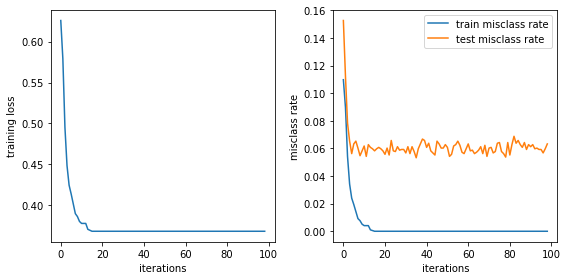

In [22]:

m,n = Xtrain.shape

train_misclass = []
test_misclass = []
train_loss = []

for d in range(1,100):
    print(d)
    clf = tree.DecisionTreeClassifier(splitter='best',max_depth=d, class_weight='balanced')
    clf = clf.fit(Xtrain, ytrain)
    train_misclass.append(get_misclass(ytrain, clf.predict(Xtrain) ))
    test_misclass.append(get_misclass(ytest, clf.predict(Xtest) ))
    train_loss.append(get_exp_loss(ytrain, clf.predict(Xtrain) ))

print(np.min(train_loss))
print(np.min(train_misclass))
print(np.min(test_misclass))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(train_loss)
plt.xlabel('iterations')
plt.ylabel('training loss')
plt.subplot(1,2,2)
plt.plot(train_misclass)
plt.plot(test_misclass)
plt.xlabel('iterations')
plt.ylabel('misclass rate')
plt.legend(['train misclass rate', 'test misclass rate'])
plt.tight_layout()
plt.savefig('mnist_notboost.png')
plt.savefig('mnist_notboost.eps')

In [17]:

m,n = Xtrain.shape
w = np.ones(m)/(m+0.)

clf = tree.DecisionTreeClassifier(splitter='best',max_depth=1, class_weight='balanced')
clf = clf.fit(Xtrain, ytrain, sample_weight = w)
print(get_misclass(ytrain, clf.predict(Xtrain) ))
print(get_misclass(ytest, clf.predict(Xtest) ))
print(get_exp_loss(ytrain, clf.predict(Xtrain) ))

0.10980592441266598
0.15268709191361124
0.6259675480492947


In [18]:

m,n = Xtrain.shape
w = np.ones(m)/(m+0.)

classifiers = []
alphas = []
T = 100
ytrain_pred_agg = ytrain*0.
ytest_pred_agg = ytest*0.

eps_track = []
alpha_track = []
train_misclass = []
test_misclass = []
train_loss = []
for t in range(T):
    clf = tree.DecisionTreeClassifier(splitter='best',max_depth=1, class_weight='balanced')
    clf = clf.fit(Xtrain, ytrain, sample_weight = w)

    eps =  get_weighted_misclass(w,ytrain, clf.predict(Xtrain) ) 
    alpha = 1./2.*np.log((1.-eps)/eps)
    
    w = w * np.exp(-alpha*ytrain*clf.predict(Xtrain))
    w = w / np.sum(w)
    
    
    ytrain_pred_agg = ytrain_pred_agg + alpha * clf.predict(Xtrain)
    ytest_pred_agg = ytest_pred_agg + alpha * clf.predict(Xtest)
    
    ytrain_pred = np.sign(ytrain_pred_agg)
    ytest_pred = np.sign(ytest_pred_agg)
    eps_track.append(eps)
    alpha_track.append(alpha)
    train_misclass.append(get_misclass(ytrain, ytrain_pred ))
    test_misclass.append(get_misclass(ytest, ytest_pred ) )
    train_loss.append(get_exp_loss(ytrain, ytrain_pred_agg))
    
    
train_loss,eps_track, alpha_track, train_misclass,test_misclass = np.array(train_loss), np.array(eps_track),np.array(alpha_track),np.array(train_misclass),np.array(test_misclass)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


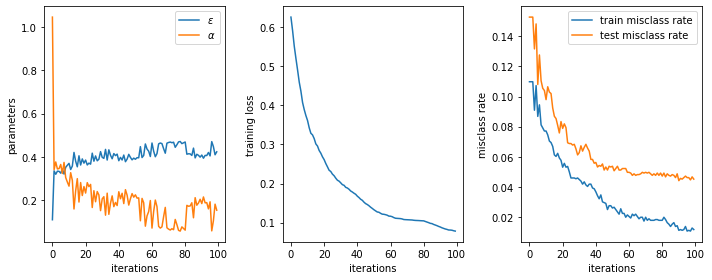

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(eps_track)
plt.plot(alpha_track)
plt.xlabel('iterations')
plt.ylabel('parameters')
plt.legend(['$\\epsilon$','$\\alpha$'])
plt.subplot(1,3,2)
plt.plot(train_loss)
plt.xlabel('iterations')
plt.ylabel('training loss')
plt.subplot(1,3,3)
plt.plot(train_misclass)
plt.plot(test_misclass)
plt.xlabel('iterations')
plt.ylabel('misclass rate')
plt.legend(['train misclass rate', 'test misclass rate'])
plt.tight_layout()
plt.savefig('mnist_adaboost.png')
plt.savefig('mnist_adaboost.eps')

In [21]:
print(np.min(train_loss))
print(np.min(train_misclass))
print(np.min(test_misclass))

0.0784886455656429
0.010725229826353423
0.04419889502762431
